In [6]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import MinMaxScaler, OneHotEncoder
from sklearn.impute import SimpleImputer
from sklearn.model_selection import train_test_split, cross_val_score
from sklearn.model_selection import RandomizedSearchCV, GridSearchCV, KFold
from sklearn.metrics import accuracy_score, recall_score, confusion_matrix, roc_curve, classification_report
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.linear_model import LogisticRegression, SGDClassifier
from sklearn.svm import LinearSVC
from xgboost import XGBRFClassifier

import sys
print(f'{np},{np.__version__}\n{pd},{pd.__version__} \n{sns},{sns.__version__},\n{sys.version}')

<module 'numpy' from 'E:\\anaconda3\\envs\\MachineLearning\\lib\\site-packages\\numpy\\__init__.py'>,1.22.3
<module 'pandas' from 'E:\\anaconda3\\envs\\MachineLearning\\lib\\site-packages\\pandas\\__init__.py'>,1.4.2 
<module 'seaborn' from 'E:\\anaconda3\\envs\\MachineLearning\\lib\\site-packages\\seaborn\\__init__.py'>,0.11.2,
3.9.12 (main, Apr  4 2022, 05:22:27) [MSC v.1916 64 bit (AMD64)]


E:\anaconda3\envs\MachineLearning\lib\site-packages\xgboost\compat.py:36: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


#### Data source: https://www.kaggle.com/datasets/vardhansiramdasu/fraudulent-transactions-prediction

In [7]:
# read the data
df = pd.read_csv(r'C:\Users\abedw\DataBases\Fraud.csv') # 470MB of data
df.shape

(6362620, 11)

In [8]:
df.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
0,1,PAYMENT,9839.64,C1231006815,170136.0,160296.36,M1979787155,0.0,0.0,0,0
1,1,PAYMENT,1864.28,C1666544295,21249.0,19384.72,M2044282225,0.0,0.0,0,0
2,1,TRANSFER,181.00,C1305486145,181.0,0.00,C553264065,0.0,0.0,1,0
3,1,CASH_OUT,181.00,C840083671,181.0,0.00,C38997010,21182.0,0.0,1,0
4,1,PAYMENT,11668.14,C2048537720,41554.0,29885.86,M1230701703,0.0,0.0,0,0


In [9]:
#np.set_printoptions(edgeitems=3)
df.describe()

,step,amount,oldbalanceOrg,newbalanceOrig,oldbalanceDest,newbalanceDest,isFraud,isFlaggedFraud
count,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06,6.362620e+06
mean,2.433972e+02,1.798619e+05,8.338831e+05,8.551137e+05,1.100702e+06,1.224996e+06,1.290820e-03,2.514687e-06
std,1.423320e+02,6.038582e+05,2.888243e+06,2.924049e+06,3.399180e+06,3.674129e+06,3.590480e-02,1.585775e-03
min,1.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
25%,1.560000e+02,1.338957e+04,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00,0.000000e+00
50%,2.390000e+02,7.487194e+04,1.420800e+04,0.000000e+00,1.327057e+05,2.146614e+05,0.000000e+00,0.000000e+00
75%,3.350000e+02,2.087215e+05,1.073152e+05,1.442584e+05,9.430367e+05,1.111909e+06,0.000000e+00,0.000000e+00
max,7.430000e+02,9.244552e+07,5.958504e+07,4.958504e+07,3.560159e+08,3.561793e+08,1.000000e+00,1.000000e+00


In [10]:
df.dtypes

step                int64
type               object
amount            float64
nameOrig           object
oldbalanceOrg     float64
newbalanceOrig    float64
nameDest           object
oldbalanceDest    float64
newbalanceDest    float64
isFraud             int64
isFlaggedFraud      int64
dtype: object

In [11]:
df['type'].value_counts()

CASH_OUT    2237500
PAYMENT     2151495
CASH_IN     1399284
TRANSFER     532909
DEBIT         41432
Name: type, dtype: int64

In [12]:
for col in df.columns:
    missing = np.mean(df[col].isnull())
    print('{}  - {}%'.format(col, missing))

step  - 0.0%
type  - 0.0%
amount  - 0.0%
nameOrig  - 0.0%
oldbalanceOrg  - 0.0%
newbalanceOrig  - 0.0%
nameDest  - 0.0%
oldbalanceDest  - 0.0%
newbalanceDest  - 0.0%
isFraud  - 0.0%
isFlaggedFraud  - 0.0%


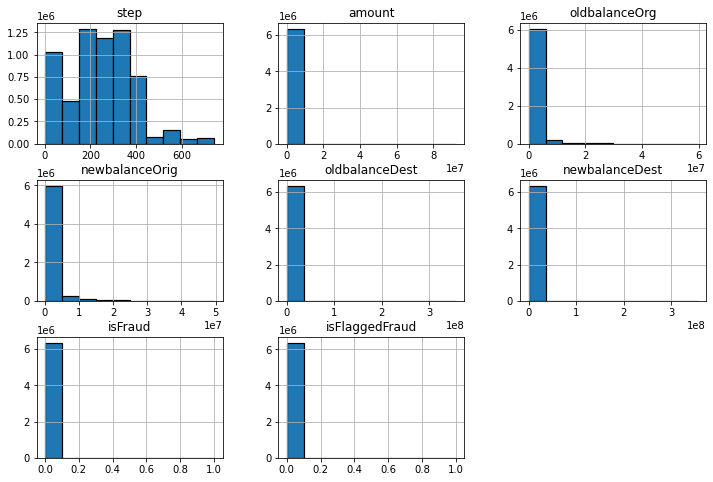

In [13]:
df.hist(edgecolor='black', linewidth=1.2, figsize=(12,8));
plt.show();

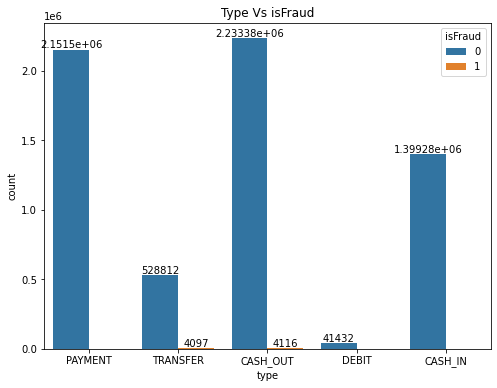

In [14]:
plt.figure(figsize=(8,6))
ax = sns.countplot(data=df,x='type',hue='isFraud')
for i in range(len(ax.containers)):
    ax.bar_label(ax.containers[i])
plt.title('Type Vs isFraud')
plt.show()

In [15]:
df['isFraud'].value_counts()

0    6354407
1       8213
Name: isFraud, dtype: int64

## From 6.3 million past transactions we have 8213 transactions that are fraud

In [16]:
df.type = pd.Categorical(df.type)

In [17]:
df['type'] = df.type.cat.codes

In [18]:
df.nameOrig = pd.Categorical(df.nameOrig)

In [19]:
df['nameOrig'] = df.nameOrig.cat.codes

In [20]:
df.nameDest = pd.Categorical(df.nameDest)

In [21]:
df['nameDest'] = df.nameDest.cat.codes

In [22]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 6362620 entries, 0 to 6362619
Data columns (total 11 columns):
 #   Column          Dtype  
---  ------          -----  
 0   step            int64  
 1   type            int8   
 2   amount          float64
 3   nameOrig        int32  
 4   oldbalanceOrg   float64
 5   newbalanceOrig  float64
 6   nameDest        int32  
 7   oldbalanceDest  float64
 8   newbalanceDest  float64
 9   isFraud         int64  
 10  isFlaggedFraud  int64  
dtypes: float64(5), int32(2), int64(3), int8(1)
memory usage: 443.0 MB


In [23]:
X = df.drop('isFraud', axis=1)
y = df['isFraud']

In [24]:
X.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
0,1,3,9839.64,757869,170136.0,160296.36,1662094,0.0,0.0,0
1,1,3,1864.28,2188998,21249.0,19384.72,1733924,0.0,0.0,0
2,1,4,181.00,1002156,181.0,0.00,439685,0.0,0.0,0
3,1,1,181.00,5828262,181.0,0.00,391696,21182.0,0.0,0
4,1,3,11668.14,3445981,41554.0,29885.86,828919,0.0,0.0,0


In [25]:
X_train, X_test, y_train, y_test = train_test_split(X,y, test_size=0.3)

In [26]:
X_train.head()

,step,type,amount,nameOrig,oldbalanceOrg,newbalanceOrig,nameDest,oldbalanceDest,newbalanceDest,isFlaggedFraud
5651638,396,1,272555.55,774659,65972.0,0.00,503181,0.00,272555.55,0
2908869,228,0,299281.38,4366353,80858.0,380139.38,502816,4830.91,0.00,0
5822304,402,3,9049.44,4860305,16721.0,7671.56,1613264,0.00,0.00,0
1678813,159,1,102317.77,2503430,69809.0,0.00,547247,0.00,102317.77,0
5406448,377,3,10649.50,2465580,343.0,0.00,1404606,0.00,0.00,0


In [47]:
%%time
np.random.seed(0)

clf = XGBRFClassifier(n_jobs=-1)
clf.fit(X_train,y_train);

[22:28:14] WARNING: ..\src\learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
CPU times: total: 38min 45s
Wall time: 2min 6s


XGBRFClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
                colsample_bytree=1, enable_categorical=False, gamma=0,
                gpu_id=-1, importance_type=None, interaction_constraints='',
                max_delta_step=0, max_depth=6, min_child_weight=1, missing=nan,
                monotone_constraints='()', n_estimators=100, n_jobs=-1,
                num_parallel_tree=100, objective='binary:logistic',
                predictor='auto', random_state=0, reg_alpha=0,
                scale_pos_weight=1, tree_method='approx', validate_parameters=1,
                verbosity=None)

In [48]:
test_preds = clf.predict(X_test)
print(classification_report(y_test,test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906279
           1       0.98      0.66      0.79      2507

    accuracy                           1.00   1908786
   macro avg       0.99      0.83      0.89   1908786
weighted avg       1.00      1.00      1.00   1908786



In [106]:
%%time
clf_rf = RandomForestClassifier(n_jobs=-1, random_state=0)

clf_rf.fit(X_train,y_train)
rf_preds = clf_rf.predict(X_test)
print(classification_report(y_test,test_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906288
           1       0.99      0.77      0.86      2498

    accuracy                           1.00   1908786
   macro avg       0.99      0.89      0.93   1908786
weighted avg       1.00      1.00      1.00   1908786

CPU times: total: 48min 8s
Wall time: 2min 20s


In [30]:
%%time
clf_etc = ExtraTreesClassifier(n_jobs=-1,random_state=0)

clf_etc.fit(X_train,y_train)
clf_etc_preds = clf_etc.predict(X_test)
print(classification_report(y_test,clf_etc_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906288
           1       1.00      0.70      0.82      2498

    accuracy                           1.00   1908786
   macro avg       1.00      0.85      0.91   1908786
weighted avg       1.00      1.00      1.00   1908786

CPU times: total: 31min 17s
Wall time: 1min 30s


In [31]:
print(clf_rf.feature_importances_),
clf_etc.feature_importances_

[0.08173118 0.05949123 0.14574441 0.02507174 0.2553667  0.03385332
 0.02593339 0.06673607 0.30535279 0.00071915]


array([0.1315944 , 0.03107466, 0.18235357, 0.04495537, 0.27973929,
       0.05782659, 0.04676774, 0.05913688, 0.16480843, 0.00174306])

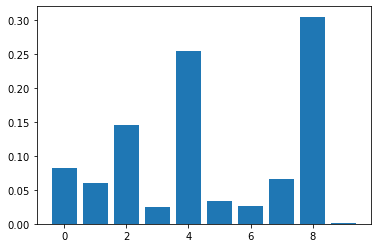

In [40]:
plt.bar(range(len(clf_rf.feature_importances_)), clf_rf.feature_importances_);

## the newbalanceDest, newbalanceORG is the most important features as the model has learned because fraud transactions usually empty balance and cash everything out

In [105]:
%%time
clf_lr = LogisticRegression(n_jobs=-1,random_state=0)

clf_lr.fit(X_train,y_train)
clf_lr_preds = clf_lr.predict(X_test)
print(classification_report(y_test,clf_lr_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906288
           1       0.81      0.44      0.57      2498

    accuracy                           1.00   1908786
   macro avg       0.91      0.72      0.78   1908786
weighted avg       1.00      1.00      1.00   1908786

CPU times: total: 1.52 s
Wall time: 53 s


In [55]:
%%time
clf_ada = AdaBoostClassifier(random_state=0)

clf_ada.fit(X_train,y_train)
clf_ada_preds = clf_ada.predict(X_test)
print(classification_report(y_test,clf_ada_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906279
           1       0.92      0.60      0.73      2507

    accuracy                           1.00   1908786
   macro avg       0.96      0.80      0.86   1908786
weighted avg       1.00      1.00      1.00   1908786

CPU times: total: 4min 31s
Wall time: 4min 39s


In [56]:
%%time
clf_sgd = SGDClassifier(n_jobs=-1, random_state=0)

clf_sgd.fit(X_train,y_train)
clf_sgd_preds = clf_sgd.predict(X_test)
print(classification_report(y_test,clf_sgd_preds))

              precision    recall  f1-score   support

           0       1.00      1.00      1.00   1906279
           1       0.73      0.56      0.63      2507

    accuracy                           1.00   1908786
   macro avg       0.87      0.78      0.82   1908786
weighted avg       1.00      1.00      1.00   1908786

CPU times: total: 28.5 s
Wall time: 29.5 s


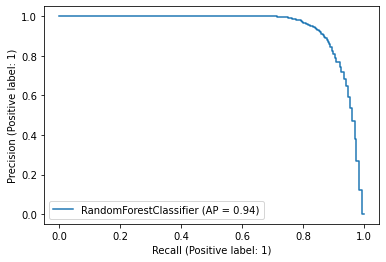

In [57]:
from sklearn.metrics import PrecisionRecallDisplay

PrecisionRecallDisplay.from_estimator(clf_rf, X_test, y_test);

In [81]:
GRID = {"n_estimators": [120,100,80,40]}

In [82]:
%%time
clf_rf_gs = GridSearchCV(clf_rf, GRID, scoring='recall', cv=5, verbose=3)

clf_rf_gs.fit(X_train,y_train)

Fitting 5 folds for each of 4 candidates, totalling 20 fits
[CV 1/5] END ..................n_estimators=120;, score=0.792 total time= 2.1min
[CV 2/5] END ..................n_estimators=120;, score=0.773 total time= 2.1min
[CV 3/5] END ..................n_estimators=120;, score=0.767 total time= 2.0min
[CV 4/5] END ..................n_estimators=120;, score=0.768 total time= 2.1min
[CV 5/5] END ..................n_estimators=120;, score=0.755 total time= 2.1min
[CV 1/5] END ..................n_estimators=100;, score=0.789 total time= 1.7min
[CV 2/5] END ..................n_estimators=100;, score=0.771 total time= 1.8min
[CV 3/5] END ..................n_estimators=100;, score=0.767 total time= 1.8min
[CV 4/5] END ..................n_estimators=100;, score=0.770 total time= 1.8min
[CV 5/5] END ..................n_estimators=100;, score=0.757 total time= 1.8min
[CV 1/5] END ...................n_estimators=80;, score=0.791 total time= 1.5min
[CV 2/5] END ...................n_estimators=80;,

GridSearchCV(cv=5, estimator=RandomForestClassifier(n_jobs=-1, random_state=0),
             param_grid={'n_estimators': [120, 100, 80, 40]}, scoring='recall',
             verbose=3)

In [83]:
clf_rf_gs.best_params_

{'n_estimators': 120}

In [144]:
THRESHOLD = 0.1
y_pred = (clf_rf_gs.predict_proba(X_test)[:,1] > THRESHOLD).astype('float')
cm = confusion_matrix(y_test, y_pred)
cm

array([[1905580,     708],
       [    216,    2282]], dtype=int64)

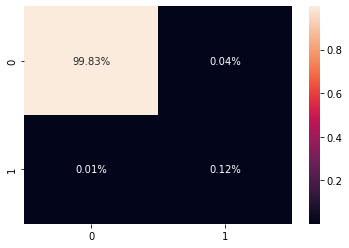

In [132]:
sns.heatmap(cm/np.sum(cm), annot=True,
           fmt='.2%');

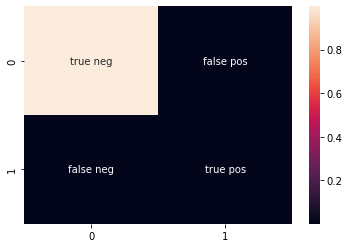

In [133]:
labels = ['true neg', 'false pos', 'false neg', 'true pos']
labels = np.asarray(labels).reshape(2,2)
sns.heatmap(cm/np.sum(cm), annot=labels,
           fmt='');

In [143]:
recall = recall_score(y_test, y_pred, average='binary')
print('model performance: %.2f' % recall)

model performance: 0.91


## building pipeline

In [ ]:
categorical_features = ["type", "nameOrig", "nameDest"]
categorical_transformer = OneHotEncoder(handle_unknown="ignore")
col_to_scale = ['step','amount','oldbalanceOrg','newbalanceOrig','oldbalanceDest','newbalanceDest']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.3, random_state=0)
preprocessor = ColumnTransformer(
    transformers=[
        ("cat", categorical_transformer, categorical_features)
         
    ])
scaler = MinMaxScaler().fit(X_train[col_to_scale])

X_train[col_to_scale] = scaler.transform(X_train[col_to_scale])
X_test[col_to_scale] = scaler.transform(X_test[col_to_scale])


clf = Pipeline(
    steps=[("preprocessor", preprocessor),
           ("model", RandomForestClassifier(n_estimators=120, n_jobs=-1))])
clf.fit(X_train, y_train)
print("model score: %.3f" % clf.score(X_test, y_test))

### exporting trained model

In [201]:
import pickle
pickle.dump(clf, open("random_forest_model.pkl", "wb"))

In [28]:
loaded_pickle_model = pickle.load(open('random_forest_model.pkl', "rb"))

In [30]:
pickle_y_preds = loaded_pickle_model.predict(X_test)

In [34]:
recall = recall_score(y_test, pickle_y_preds, average='binary')
print('model performance: %.2f' % recall)

model performance: 0.70


## Resault
* More improvemts can be done on the model
** model is built on preventive measure, model can be relaxed for robust speed and still yield good performance
*** set up authentication step for activity that model is 10% confident is suspecious 
**** implementation can discourage Fraudelent transaction and might see attemps fall